In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/d2l.ai_implementation/chapter8'

/content/drive/MyDrive/d2l.ai_implementation/chapter8


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from matplotlib import pyplot as plt

In [ ]:
#from ResNet import ResNet
from DenseNet import DenseNet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
transform = T.Compose([
    T.Resize((96, 96)),
    T.ToTensor(),
    T.Normalize(0.2860, 0.3530)
])

In [4]:
root = '/content'
train_set = datasets.FashionMNIST(
    root,
    train=True,
    transform=transform,
    download=True
)
test_set = datasets.FashionMNIST(
    root,
    train=False,
    transform=transform,
    download=True
)

100%|██████████| 26421880/26421880 [00:16<00:00, 1598530.54it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270301.59it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1433209.18it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6160421.40it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [ ]:
batch_size = 128

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# resnet_arch = [(2,64), (2,128), (2,256), (2, 512)]
model_for_summary = DenseNet().to(device)
summary(model_for_summary, (1, 96, 96))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

In [ ]:
input = torch.randn(1, 1, 96, 96).float().to(device)
out = model_for_summary(input)
print(out)

tensor([[-0.4153, -0.0024,  0.0069,  0.1027,  0.0947,  0.0390, -0.2683,  0.3312,
         -0.2622, -0.1491]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
def train_run_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [ ]:
def test_run_epoch(model, device, test_loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            pred = output.argmax(1)
            correct += pred.eq(target).sum().item()

            total_loss += loss.item()

        accuracy = correct / len(test_set)
        avg_loss = total_loss / len(test_loader)

    return accuracy, avg_loss

In [ ]:
def train(model, device, train_loder, test_loader, optimizer, criterion, num_epochs):
    train_avg_losses = []
    test_avg_losses = []
    accuracies = []

    for epoch in range(1, num_epochs+1):
        print(f"Epoch [{epoch}/{num_epochs}]")

        train_avg_loss = train_run_epoch(model, device, train_loader, optimizer, criterion)
        train_avg_losses.append(train_avg_loss)
        print(f"Average Train Loss = {train_avg_loss:.20f}")

        accuracy, test_avg_loss = test_run_epoch(model, device, test_loader)
        test_avg_losses.append(test_avg_loss)
        accuracies.append(accuracy)
        print(f"Average Test Loss = {test_avg_loss:.20f}")
        print(f"Test Accuracy = {accuracy:.2f}")
        print()

    return train_avg_losses, test_avg_losses, accuracies

In [ ]:
num_epochs = 10
learning_rate = 0.01

# resnet = ResNet(arch).to(device)
densenet = DenseNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=learning_rate)

In [ ]:
train_losses, test_losses, accuracies = train(densenet, device, train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/10]


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Average Train Loss = 0.67824284888025543339
Average Test Loss = 0.57805229780040212617
Test Accuracy = 0.78

Epoch [2/10]
Average Train Loss = 0.34397445959068817523
Average Test Loss = 0.36124975432323502833
Test Accuracy = 0.87

Epoch [3/10]
Average Train Loss = 0.27983036379951403694
Average Test Loss = 0.32690825954645497120
Test Accuracy = 0.88

Epoch [4/10]
Average Train Loss = 0.24476280646410578101
Average Test Loss = 0.43598762418650371941
Test Accuracy = 0.85

Epoch [5/10]
Average Train Loss = 0.22532119096786989987
Average Test Loss = 0.25339330855426911437
Test Accuracy = 0.91

Epoch [6/10]
Average Train Loss = 0.20555352958153561005
Average Test Loss = 0.28065359290642072354
Test Accuracy = 0.90

Epoch [7/10]
Average Train Loss = 0.19056201956546636733
Average Test Loss = 0.29443526532076580438
Test Accuracy = 0.89

Epoch [8/10]
Average Train Loss = 0.17713374279137614198
Average Test Loss = 0.25196733278564259484
Test Accuracy = 0.91

Epoch [9/10]
Average Train Loss = 0.1

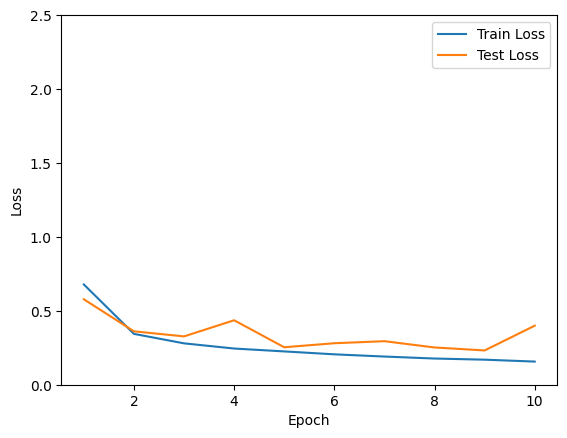

In [ ]:
X = range(1, num_epochs+1)
plt.plot(X, train_losses, label="Train Loss")
plt.plot(X, test_losses, label="Test Loss")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 2.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

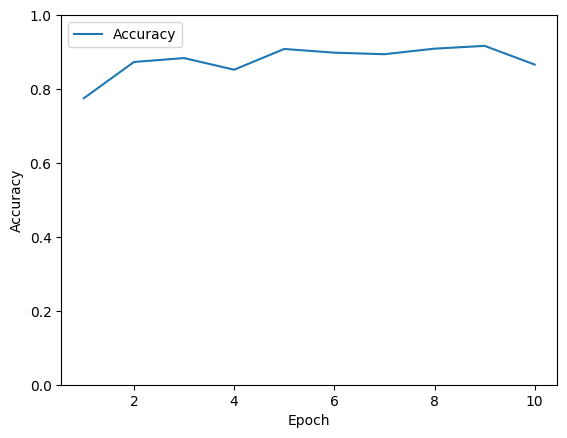

In [ ]:
plt.plot(X, accuracies, label="Accuracy")
plt.xticks(range(2, num_epochs+1, 2))
plt.legend()
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()